<a href="https://colab.research.google.com/github/deepakra0/tf/blob/Preprocessing/tf_BC_kp_binclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data'
df = pd.read_csv(url
                 ,na_values='?'
                 ,names = ['recurrence', 'age', 'menopause', 'tumorsize', 'invnodes', 'nodecaps', 'degmalig', 'breast', 'breastquad' , 'irradiat']
)
df.dropna(inplace=True)

In [2]:
ds = tf.data.Dataset.from_tensor_slices((dict(df.iloc[:,1:]), df.iloc[:,0].replace({'no-recurrence-events': 0, 'recurrence-events': 1})))
ds = ds.shuffle(buffer_size=len(df))

In [3]:
train_ds = ds.take(200)
train_ds = train_ds.batch(batch_size=20)
test_ds = ds.skip(200)
test_ds = test_ds.batch(batch_size=11)

In [4]:
input_layers = []
encoded_features = []
for key in ds.element_spec[0].keys():
  feature = ds.map(lambda x, y: x[key])
  feature = feature.map(lambda x: tf.expand_dims(x, -1))
  if ds.element_spec[0][key].dtype == 'string':
    categorize = tf.keras.layers.experimental.preprocessing.StringLookup(output_mode='binary')
    categorize.adapt(feature)
    tmp_layer = tf.keras.Input(shape=(1,),name=key,dtype=tf.string)
    encoded_features.append(categorize(tmp_layer))
    input_layers.append(tmp_layer)
  elif ds.element_spec[0][key].dtype == 'int64':
    normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
    normalizer.adapt(feature)
    tmp_layer = tf.keras.Input(shape=(1,),name=key)
    encoded_features.append(normalizer(tmp_layer))
    input_layers.append(tmp_layer)

In [20]:
concat_feature = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(18,activation='relu')(concat_feature)
x = tf.keras.layers.Dense(18,activation='relu')(x)
output = tf.keras.layers.Dense(1,activation='sigmoid')(x)
model = tf.keras.Model(input_layers,output)
model.compile("adam", "binary_crossentropy", metrics=[
                                                      tf.keras.metrics.Accuracy()
                                                      ,tf.keras.metrics.Precision()
                                                      ,tf.keras.metrics.Recall()])

In [34]:
history = model.fit(train_ds, epochs=50, validation_data=test_ds, verbose=0)

In [35]:
for blk in iter(test_ds):
    result = model.predict(blk[0])
    print('Actual: {} Predicted: {}'.format(blk[1].numpy(),result.round().T ))

Actual: [1 0 0 0 0 0 1 0 0 0 0] Predicted: [[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual: [0 1 0 0 1 0 1 1 1 0 0] Predicted: [[0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.]]
Actual: [0 0 0 0 0 0 1 0 1 0 1] Predicted: [[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]]
Actual: [1 0 0 0 0 0 0 0 0 0 0] Predicted: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual: [0 0 0 0 0 0 1 1 0 1 1] Predicted: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]]
Actual: [0 0 0 0 1 0 1 0 0 1 1] Predicted: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]]
Actual: [0 1 0 0 0 0 1 0 1 0 0] Predicted: [[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.]]


In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

In [31]:
import matplotlib.pyplot as plt

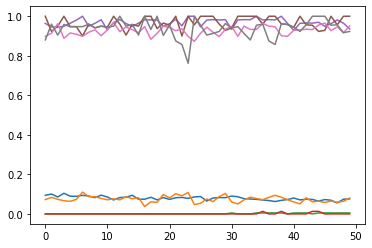

In [37]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()